In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('df_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893300 entries, 0 to 1893299
Data columns (total 20 columns):
 #   Column              Dtype  
---  ------              -----  
 0   code_insee_region   int64  
 1   region              object 
 2   nature              object 
 3   date                object 
 4   heure               object 
 5   date_heure          object 
 6   consommation_mw     float64
 7   thermique_mw        float64
 8   nucleaire_mw        float64
 9   eolien_mw           float64
 10  solaire_mw          float64
 11  hydraulique_mw      float64
 12  pompage_mw          float64
 13  bioenergies_mw      float64
 14  ech._physiques_mw   float64
 15  total_prod          float64
 16  prod_energie_green  float64
 17  jour                int64  
 18  mois                int64  
 19  annee               int64  
dtypes: float64(11), int64(4), object(5)
memory usage: 288.9+ MB


In [3]:
df = df.drop(['code_insee_region','region','nature'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893300 entries, 0 to 1893299
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   heure               object 
 2   date_heure          object 
 3   consommation_mw     float64
 4   thermique_mw        float64
 5   nucleaire_mw        float64
 6   eolien_mw           float64
 7   solaire_mw          float64
 8   hydraulique_mw      float64
 9   pompage_mw          float64
 10  bioenergies_mw      float64
 11  ech._physiques_mw   float64
 12  total_prod          float64
 13  prod_energie_green  float64
 14  jour                int64  
 15  mois                int64  
 16  annee               int64  
dtypes: float64(11), int64(3), object(3)
memory usage: 245.6+ MB


Nous avons enlever les colonnes qui ne nous servent pas pour notre modèle de ML comme code insee, nature et région car nous allons chercher à prédire la consommation nationale.

In [4]:
df_mois= df.groupby(['mois','annee'])['consommation_mw','thermique_mw','nucleaire_mw','eolien_mw','solaire_mw','hydraulique_mw','pompage_mw','bioenergies_mw','ech._physiques_mw'].sum()
df_jours = df.groupby(['jour','mois','annee'])['consommation_mw','thermique_mw','nucleaire_mw','eolien_mw','solaire_mw','hydraulique_mw','pompage_mw','bioenergies_mw','ech._physiques_mw'].sum()

/var/folders/9j/vr6nk47j60zf1n4c0gxl6c5m0000gn/T/ipykernel_3123/2067356966.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mois= df.groupby(['mois','annee'])['consommation_mw','thermique_mw','nucleaire_mw','eolien_mw','solaire_mw','hydraulique_mw','pompage_mw','bioenergies_mw','ech._physiques_mw'].sum()
/var/folders/9j/vr6nk47j60zf1n4c0gxl6c5m0000gn/T/ipykernel_3123/2067356966.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_jours = df.groupby(['jour','mois','annee'])['consommation_mw','thermique_mw','nucleaire_mw','eolien_mw','solaire_mw','hydraulique_mw','pompage_mw','bioenergies_mw','ech._physiques_mw'].sum()


In [33]:
df_mois.head()

consommation_mw  thermique_mw  nucleaire_mw  eolien_mw  \
mois annee                                                           
1    2013       106515355.0    12575951.0    84708335.0  2627826.0   
     2014        98093825.0     6206649.0    85322280.0  4381714.0   
     2015       104474826.0     9874454.0    87536369.0  4590596.0   
     2016        99742979.0     9444818.0    83118436.0  5689514.0   
     2017       114162972.0    16302250.0    80955924.0  4087667.0   

            solaire_mw  hydraulique_mw  pompage_mw  bioenergies_mw  \
mois annee                                                           
1    2013     275544.0      13618137.0  -1204944.0       1089974.0   
     2014     341160.0      13876090.0  -1563172.0       1366898.0   
     2015     487522.0      12331411.0  -1303015.0       1385188.0   
     2016     536436.0      11211390.0  -1528748.0       1547909.0   
     2017     713220.0      10287298.0  -1130472.0       1656086.0   

            ech._physiques_mw  
mois annee                     
1    2013          -7229744.0  
     2014         -11836007.0  
     2015         -10427391.0  
     2016         -10276181.0  
     2017           1291938.0

Nous avons créé deux dataframe rééchantillonner pour pouvoir faire travailler notre modèle par mois et par jour.

# Modèle par mois

               Ridge

In [6]:
data = df_mois.drop('consommation_mw', axis=1)
target = df_mois['consommation_mw']

scaler = preprocessing.StandardScaler().fit(data)

data[data.columns] = pd.DataFrame(scaler.transform(data), index=data.index)

In [32]:
target.head()

mois  annee
1     2013     106515355.0
      2014      98093825.0
      2015     104474826.0
      2016      99742979.0
      2017     114162972.0
Name: consommation_mw, dtype: float64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle = False)

In [8]:
from sklearn.linear_model import RidgeCV

ridge_reg = RidgeCV(alphas= (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100))
ridge_reg.fit(X_train, y_train) 

RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 3.e-01, 7.e-01, 1.e+00, 1.e+01, 5.e+01,
       1.e+02]))

In [9]:
print('alpha sélectionné par c-v :', ridge_reg.alpha_)
print('score train :', ridge_reg.score(X_train, y_train))
print('score test :', ridge_reg.score(X_test, y_test))

alpha sélectionné par c-v : 0.001
score train : 0.9999993227743113
score test : 0.9999980914515928


In [10]:
ridge_pred_train = ridge_reg.predict(X_train)
ridge_pred_test = ridge_reg.predict(X_test)

print('mse train :', mean_squared_error(ridge_pred_train, y_train))
print('mse test :', mean_squared_error(ridge_pred_test, y_test))

mse train : 131702231.97059858
mse test : 159484220.76286185


                LASSO

In [11]:
from sklearn.linear_model import Lasso

lasso_r = Lasso(alpha=1)

lasso_r.fit(X_train, y_train)

Lasso(alpha=1)

In [12]:
lasso_r.coef_

array([3579650.67725764, 9206086.04766159, 2095475.41723399,
        849283.825721  , 2757986.55996717,  209987.74765381,
        198972.91714512, 4264140.0330566 ])

In [13]:
lasso_reg = Lasso(alpha=0.1)

lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.1)

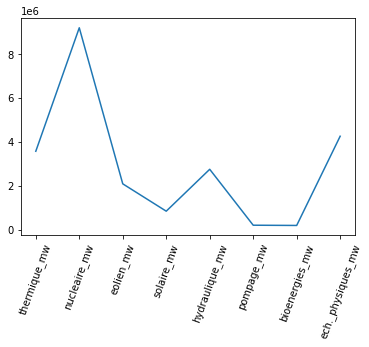

In [14]:
lasso_coef = lasso_reg.coef_

plt.plot(range(len(data.columns)), lasso_coef)
plt.xticks(range(len(data.columns)), data.columns.values, rotation=70);

In [15]:
print('score train :', lasso_reg.score(X_train, y_train))
print('score test :', lasso_reg.score(X_test, y_test))

score train : 0.9999993030483979
score test : 0.9999982210300846


In [16]:
lasso_pred_train = lasso_reg.predict(X_train)
lasso_pred_test = lasso_reg.predict(X_test)

print('mse train :', mean_squared_error(lasso_pred_train, y_train))
print('mse test :', mean_squared_error(lasso_pred_test, y_test))

mse train : 135538393.02445734
mse test : 148656240.33891752


In [17]:
from sklearn.linear_model import lasso_path

mes_alphas = (0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0)

alpha_path, coefs_lasso, _ = lasso_path(X_train, y_train, alphas=mes_alphas)

coefs_lasso.shape

(8, 10)

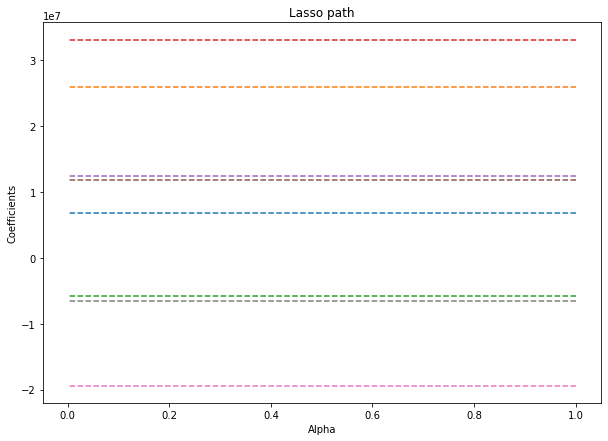

In [18]:
plt.figure(figsize=(10, 7))

for i in range(coefs_lasso.shape[0]):
    plt.plot(alpha_path, coefs_lasso[i,:], '--')

plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path');

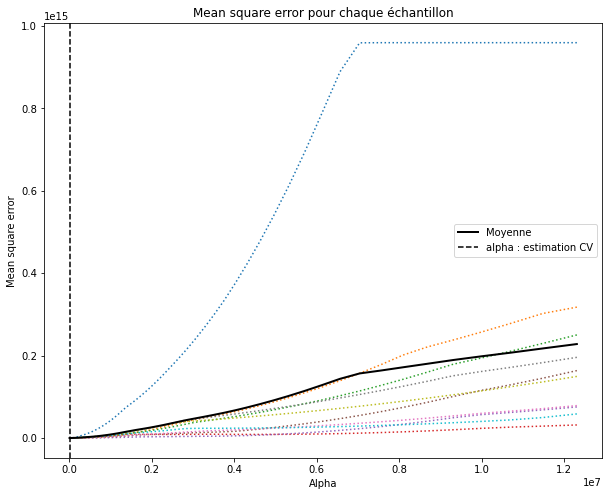

In [19]:
from sklearn.linear_model import LassoCV

model_lasso = LassoCV(cv=10).fit(X_train, y_train)

alphas = model_lasso.alphas_

plt.figure(figsize=(10, 8))

plt.plot(alphas, model_lasso.mse_path_, ':')
plt.plot(alphas, model_lasso.mse_path_.mean(axis=1), 'k', label='Moyenne', linewidth=2)

plt.axvline(model_lasso.alpha_, linestyle='--', color='k', label='alpha : estimation CV')

plt.xlabel('Alpha')
plt.ylabel('Mean square error')
plt.title('Mean square error pour chaque échantillon')
plt.legend();

In [20]:
pred_test = model_lasso.predict(X_test)

print('score test :', model_lasso.score(X_test, y_test))
print('mse test :', mean_squared_error(pred_test, y_test))

score test : 0.9999345504433308
mse test : 5469167826.898232


            ELASTIC NET

In [21]:
from sklearn.linear_model import ElasticNetCV

model_en = ElasticNetCV(cv=8, 
                        l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0))

model_en.fit(X_train, y_train)

ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
             cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99))

In [22]:
coeffs = list(model_en.coef_)
coeffs.insert(0, model_en.intercept_)
feats = list(data.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'valeur estimée': coeffs}, index=feats)

,valeur estimée
intercept,7.864162e+07
thermique_mw,3.579784e+06
nucleaire_mw,9.205596e+06
eolien_mw,2.095401e+06
solaire_mw,8.487218e+05
hydraulique_mw,2.757998e+06
pompage_mw,2.100915e+05
bioenergies_mw,1.992081e+05
ech._physiques_mw,4.263834e+06


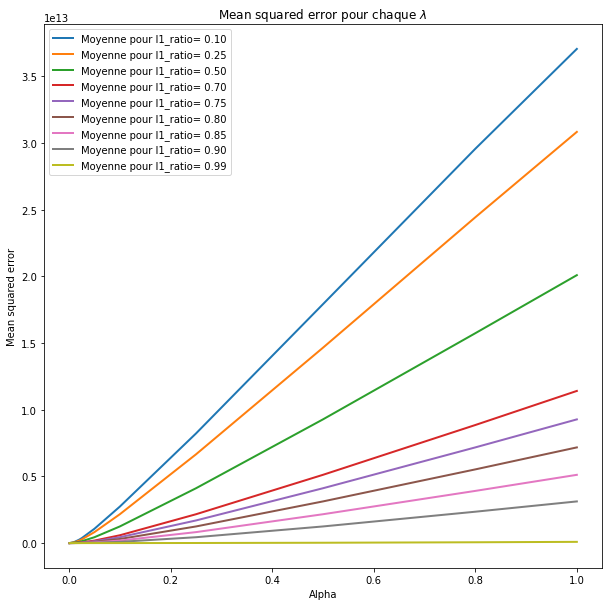

In [23]:
alphas = model_en.alphas_

plt.figure(figsize=(10, 10))

for i in range(model_en.mse_path_.shape[0]) :
    plt.plot(alphas, model_en.mse_path_[i,:,:].mean(axis=1),
             label='Moyenne pour l1_ratio= %.2f' %model_en.l1_ratio[i], linewidth=2)

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error pour chaque $\lambda$')
plt.legend();

In [24]:
pred_train = model_en.predict(X_train)
pred_test = model_en.predict(X_test)
print(np.sqrt(mean_squared_error(y_train, pred_train)))
print(np.sqrt(mean_squared_error(y_test, pred_test)))

11617.101184036332
12313.832172683577


In [25]:
print('score train :', model_en.score(X_train, y_train))
print('score test :', model_en.score(X_test, y_test))

score train : 0.9999993060377722
score test : 0.9999981854375509


In [26]:
moy = scaler.mean_[-1]
ec = scaler.scale_[-1]
print('moyenne :', moy)
print('ecart-type :', ec)

moyenne : -8859653.5
ecart-type : 4269731.952569743


In [27]:
pd.DataFrame({'conso_observés': (y_test*ec)+moy, 'conso_predits' : np.round((pred_test*ec)+moy)}, 
             index=X_test.index).head(7)

conso_observés  conso_predits
mois annee                               
10   2018     3.147050e+14   3.146893e+14
     2019     3.085202e+14   3.084925e+14
     2020     3.253781e+14   3.253920e+14
     2021     3.121905e+14   3.121908e+14
11   2013     3.846749e+14   3.845756e+14
     2014     3.450023e+14   3.450011e+14
     2015     3.488026e+14   3.488257e+14